In [2]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [11:13:10] Enabling RDKit 2019.09.3 jupyter extensions


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.984386
epoch: 0, lr: 0.01
train loss: 19201.32078269676, val loss: 12989.934765625
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:10.774455
epoch: 10, lr: 0.01
train loss: 450.48255637839986, val loss: 406.7381072998047
sklearn train metric: 0, sklearn validation metric: 0
test loss: 327.79901123046875
learning time: 0:00:19.942210
sklearn test metric: 
0 



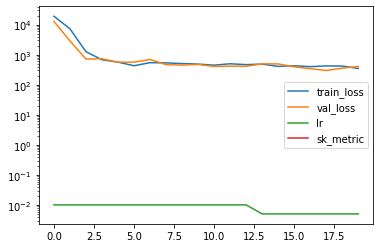

In [8]:
## Example using scikit dataset wrapper SKDS and custom model
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.980797
epoch: 0, lr: 0.01
train loss: 1531.2722296463817, val loss: 1501.6554870605469
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.609225
epoch: 10, lr: 0.01
train loss: 33.91697542290939, val loss: 36.699997901916504
sklearn train metric: 0, sklearn validation metric: 0
test loss: 32.24605894088745
learning time: 0:00:21.644073
sklearn test metric: 
0 



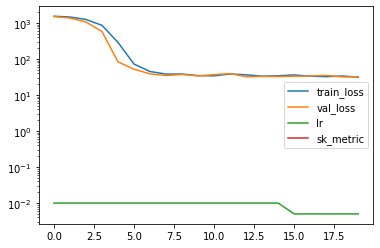

In [2]:
## Example using QM7 dataset and custom model with embeddings
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,None,True)]}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'embeds': ['atoms'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.054862
epoch: 0, lr: 0.01
train loss: 1562.2833444695723, val loss: 1545.4393005371094
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:09.171339
epoch: 10, lr: 0.01
train loss: 56.134045249537415, val loss: 61.8054313659668
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:16.821738
epoch: 20, lr: 0.01
train loss: 47.00850637335526, val loss: 56.06629657745361
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:24.507532
epoch: 30, lr: 0.005
train loss: 41.75597823293585, val loss: 50.23487949371338
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:32.096851
epoch: 40, lr: 0.0025
train loss: 38.20848746048777, val loss: 50.91471767425537
sklearn train metric: 0, sklearn validation metric: 0
test loss: 50.60513401031494
learning time: 0:00:39.375706
sklearn test metric: 
0 



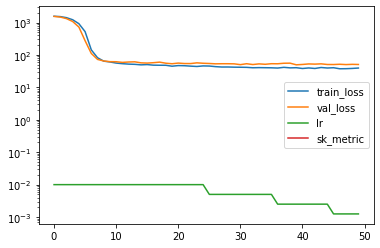

In [3]:
## Example using the QM7b dataset
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [4]:
## Find the longest molecule in the QM7X dataset
ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
longest molecule length:  23


(array([6., 1., 1., 1., 1.], dtype=float32), [], [])

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.365717
epoch: 0, lr: 0.01
train loss: 66.12383752120168, val loss: 44.68240928649902
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.022536
epoch: 9, lr: 0.01
train loss: 2.4912185668945312, val loss: 2.617420732975006
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:13.210936
epoch: 10, lr: 0.01
train loss: 2.288787979828684, val loss: 2.087994337081909
sklearn train metric: 0, sklearn validation metric: 0
le

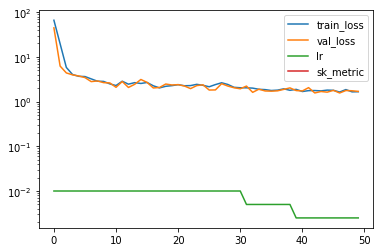

In [5]:
## Example using the QM7X dataset and custom model with embeddings
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'do_not_pad':['eAT'],
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  1
total uncharacterized molecules removed:  273
total QM9 molecules created:  9727
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.334890
epoch: 0, lr: 0.01
train loss: 337.1465348463792, val loss: 289.367529296875
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.041069
epoch: 9, lr: 0.01
train loss: 8.58659133544335, val loss: 7.588672065734864
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:13.227302
epoch: 10, lr: 0.01
train loss: 8.199295117304874, val loss: 8.579329109191894
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:24.068412
epoch: 19, lr: 0.01
train loss: 7.790128451127273, val loss: 7.554365730285644
sklearn train metric: 0, sklearn validation metric: 0
test loss: 7.640756702423095
learning time: 0:00:24.533654
sklearn test metric: 
0 



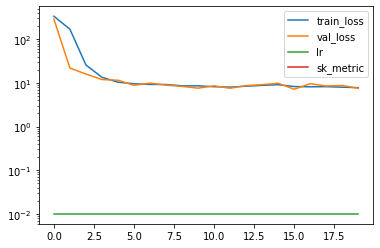

In [6]:
## Example using the QM9 dataset
model_params = {'D_in': 29*29+12+29,
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 10000, 
                              'features': ['n_atoms','A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [], 
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['n_atoms','A','B','C','mu','alpha','homo','lumo',
                                             'gap','r2','zpve','Cv','U0'],
                              'filter_on': None,
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  0
QM9 molecules scanned:  10001
QM9 molecules created:  1853
QM9 molecules scanned:  20001
QM9 molecules created:  4109
QM9 molecules scanned:  30001
QM9 molecules created:  5164
QM9 molecules scanned:  40001
QM9 molecules created:  8487
total uncharacterized molecules removed:  66
total QM9 molecules created:  9934
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.413467
epoch: 0, lr: 0.01
train loss: 355.6630689832899, val loss: 304.3226013183594
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:11.466751
epoch: 8, lr: 0.01
train loss: 8.580296498757821, val loss: 7.673767852783203
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:14.004917
epoch: 10, lr: 0.01
train loss: 7.8297684987386065, val loss: 7.503078842163086
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:24.095310
epoch: 18, lr: 0.01
train loss:

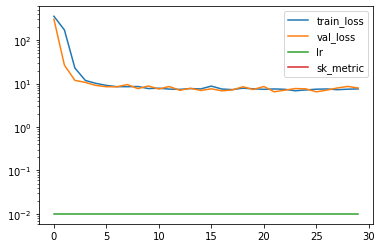

In [7]:
## Example using the QM9 dataset filter
model_params = {'D_in': 29*29+29+12, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {'n': 10000,
                              'features': ['n_atoms','A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['n_atoms','A','B','C','mu','alpha','homo','lumo',
                                             'gap','r2','zpve','Cv','U0'],
                              'filter_on': ('n_atoms','>','18'),
                              'use_pickle': False,
                              'flatten': True}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=30)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:05.755647
epoch: 0, lr: 0.01
train loss: 564.6212265912225, val loss: 530.7169799804688
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:17.396970
epoch: 6, lr: 0.01
train loss: 39.19345810834099, val loss: 36.48549016316732
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:25.106710
epoch: 10, lr: 0.01
train loss: 37.979500377879425, val loss: 33.13790384928385
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:36.776086
epoch: 16, lr: 0.005
train loss: 28.411951177260455, val loss: 25.274171829223633
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:44.503816
epoch: 20, lr: 0.005
train loss: 28.826579262228574, val loss: 36.77651341756185
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:56.044

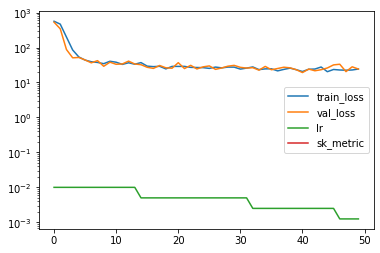

In [3]:
## Example using ANI1x dataset with filter and embeddings with a custom model
model_params = {'D_in': 63*63+63*32, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=50)